# CH7_RNN을 사용한 문장 생성
> 이번 장에서는 언어 모델을 사용해 '문장 생성'을 수행한다. 구체적으로는 우선 말뭉치를 사용해 학습한 언어 모델을 이용하여 샐운 문장을 만들어 낸다. 그런 다음 개선된 언어 모델을 이용하여 더 자연스러운 문장을 생성하는 모습을 선보이겠다. 여기까지 해보면 AI로 글을 쓰게 한다라는 개념을 실감할 수 있을 것이다.<br><br> 여기서 멈추지 않고 seq2seq라는 새고운 구조의 싱경망도 다룬다. 시계열에서 시계열로 라는 뜻으로 한 시계열 데이터를 다른 시계열 데이터로 변환하는 것을 말한다. 이 seq2seq는 기계번역, 챗봇, 메일의 자동 답신 등 다양하게 응용될 수 있다.


## 1. 언어 모델을 사용한 문장 생성

### 1) RNN을 사용한 문장 생성의 순서

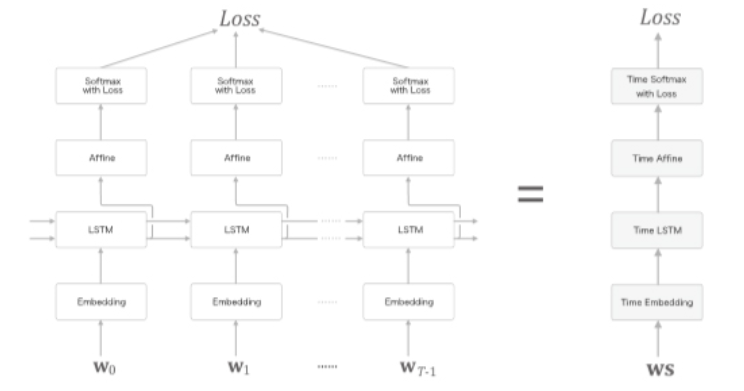

### 2) 문장 생성 구현

In [9]:
import sys
sys.path.append('C:\pythonStudy\밑시딥2\deep-learning-from-scratch-2-master\deep-learning-from-scratch-2-master')
import numpy as np
from common.functions import softmax
from ch06.rnnlm import Rnnlm
from ch06.better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
  def generate(self, start_id, skip_ids = None, sample_size=100):
    word_ids = [start_id] # 최초로 주는 단어의 ID

    x = start_id 
    while len(word_ids) < sample_size:
      x = np.array(x).reshape(1,1)
      score = self.predict(x)
      p = softmax(score.flatten())

      sampled = np.random.choice(len(p), size=1, p=p)
      if (skip_ids is None) or (sampled not in skip_ids): # skip_id는 단어 ID의 리스트
        x = sampled
        word_ids.append(int(x))

    return 

In [12]:
import sys
sys.path.append('C:\pythonStudy\밑시딥2\deep-learning-from-scratch-2-master\deep-learning-from-scratch-2-master')
from ch07.rnnlm_gen import RnnlmGen
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
corpus_size = len(corpus)

model = RnnlmGen()
model.load_params('C:\pythonStudy\밑시딥2\deep-learning-from-scratch-2-master\deep-learning-from-scratch-2-master\ch06\Rnnlm.pkl')

# start 문자와 skip 문자 설정
start_word = 'you'
start_id = word_to_id[start_word]
skip_words = ['N', '<unk>', '$']
skip_ids = [word_to_id[w] for w in skip_words]
# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids]) # 단어 ID 배열을 문장으로 변환
txt = txt.replace(' <eos>', '.\n')
print(txt)


you a tokyo and possibly sharp interest at the end price plus serious investors communications.
 real estate was off with to introduce u.s. corporations.
 u.s. data prices said he will cause a single move required to resume as hedge in cadillac paid such equipment more growth.
 the costs total of at&t is paying too high.
 on the conference of a single forge effort by the leading thursday buy the largest industry entertainment & poor 's corp. sears had gained a climb to replace petrie europe and acquired the second board.
 however they recovered his first


In [13]:
' '.join(['you','say','goodbye'])

'you say goodbye'

In [6]:
import sys
sys.path.append('C:\pythonStudy\밑시딥2\deep-learning-from-scratch-2-master\deep-learning-from-scratch-2-master/')
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from ch07.seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq

# 데이터셋 읽기
(x_train, t_tain), (x_test, t_test) = sequence.load_data('addition.txt')


### 3) 더 좋은 문장으로 

## 2. seq2seq
> 시계열 데이터를 다른 시계열 데이터로 변환하는 모델

### 1) seq2seq의 원리
> seq2seq를 Encoder-Decoder 모델이라고도 한다. 여기에서는 2개의 Encoder와 Decoder가 등장한다. 문자 그대로 Encoder는 입력 데이터를 인코딩하고, Decoder는 인코딩된 데이터를 디코딩한다.

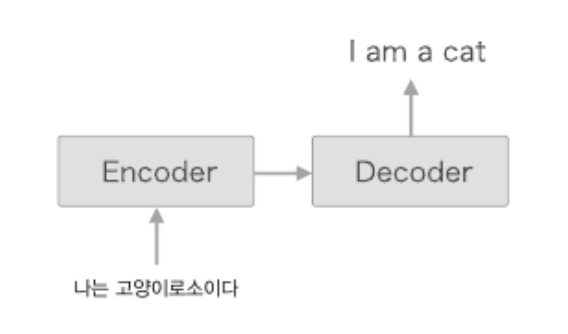

Encoder층을 구성하는 계층

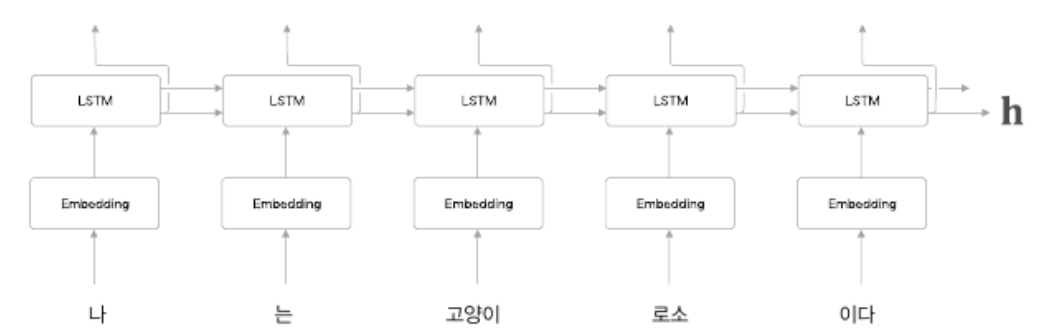

- Encoder는 RNN을 이용해 시계열 데이터 h라는 은닉상태 벡터로 변환한다.
- Encoder가 출력하는 벡터 h는 LSTM계층의 마지막 은닉 상태이다.
- 이 마지막 은닉상태 h에 문장을 번역하는 데 필요한 정보가 인코딩이다.
- 여기서 중요한 점은 LSTM의 은닉상태 h는 고정 길이 벡터라는 것이다.
- 그래서 인코딩한다라함은 결국 임의의 길이의 문장을 고정 길이 벡터로 변환하는 작업이 된다.

Decoder를 구성하는 계층

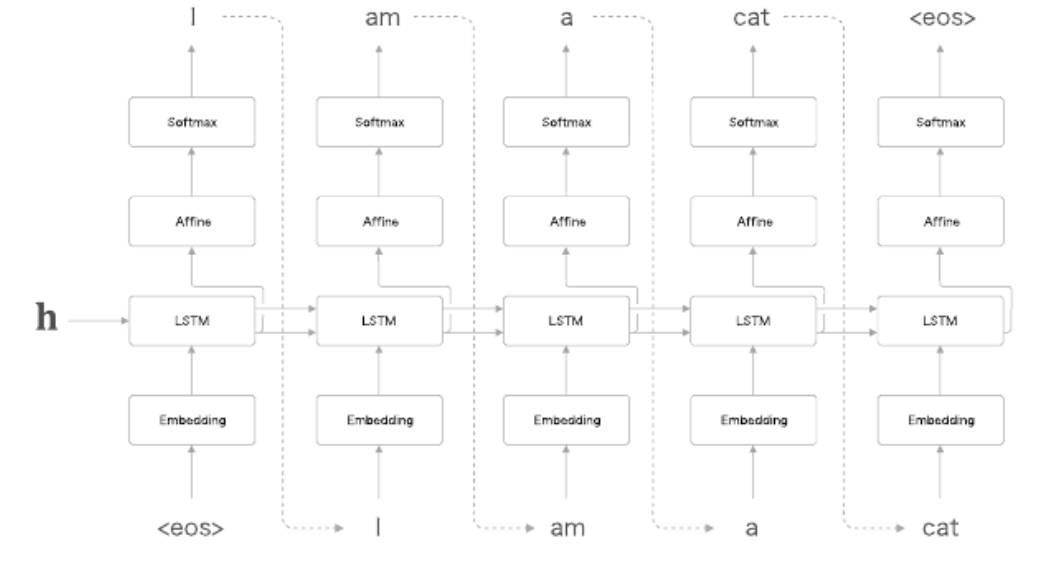

- 앞절의 신경망과 완전히 같은 구성이다. 다른 점이 있다면
- LSTM계층이 벡터 h를 입력받는다는 점이 다르다.
- 참고로, 앞 절의 언어 모델에서는 LSTM계층이 아무것도 받지 않는다.
- 이처ㅇ럼 단 하나의 사소한 차이가 평범한 언어 모델을 번역도 해낼 수 있는 Decoder로 탈바꿈 시킨다.